In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, OneHotEncoder, StandardScaler, minmax_scale
from torch.utils.data import DataLoader, Dataset, TensorDataset
from torchvision.transforms import v2

from main_event import prepare_event_data, prepare_json_event_data
from models.lstm import LSTM
from models.gru import GRU
from models.main import get_model, test_model, train_model
from preprocessing import PreProcessing
from utils import (
    add_shot_prediction_features,
    calculate_velocity_acceleration,
    calculate_velocity_direction,
    calculate_velocity_acceleration_direction,
    calculate_player_ball_distances,
    get_n_smallest_indices_sorted,
    get_frame_data,
    process_event_data, 
    plot_confusion_matrix, 
    plot_accuracy_history
)

## You'll see the data goes from 0 to 1 on each axis. The coordiante (0,0) is the top left, (1,1) is the bottom right, and (0.5,0.5) is the kick off point.

In [2]:
game_1_pre = PreProcessing()
game_1_data = game_1_pre.load_and_process_data(
    data_home="data/Sample_Game_1/Sample_Game_1_RawTrackingData_Home_Team.csv", 
    data_away="data/Sample_Game_1/Sample_Game_1_RawTrackingData_Away_Team.csv", 
    add_ball_data=True, 
    remove_ball_nan=False
)

In [3]:
game_2_pre = PreProcessing()
game_2_data = game_2_pre.load_and_process_data(
    data_home="data/Sample_Game_2/Sample_Game_2_RawTrackingData_Home_Team.csv", 
    data_away="data/Sample_Game_2/Sample_Game_2_RawTrackingData_Away_Team.csv", 
    add_ball_data=True, 
    remove_ball_nan=False
)

In [4]:
game_3_pre = PreProcessing()
game_3_data = game_3_pre.load_and_process_json_data(
    data_home_away="data/Sample_Game_3/Sample_Game_3_tracking.txt", 
    add_ball_data=True, 
    remove_ball_nan=False
)

In [5]:
# game_1_data.iloc[:, 25:-2] = -1 * game_1_data.iloc[:, 25:-2]
game_1_data

,Period,Frame,Time [s],Home-Player11-x,Home-Player11-y,Home-Player1-x,Home-Player1-y,Home-Player2-x,Home-Player2-y,Home-Player3-x,...,Away-Player21-x,Away-Player21-y,Away-Player22-x,Away-Player22-y,Away-Player23-x,Away-Player23-y,Away-Player24-x,Away-Player24-y,Ball-x,Ball-y
1,1.0,1.0,0.04,0.00082,0.48238,0.32648,0.65322,0.33701,0.48863,0.30927,...,0.55243,0.43269,0.50067,0.94322,0.43693,0.05002,0.37833,0.27383,0.45472,0.38709
2,1.0,2.0,0.08,0.00096,0.48238,0.32648,0.65322,0.33701,0.48863,0.30927,...,0.55243,0.43269,0.50067,0.94322,0.43693,0.05002,0.37833,0.27383,0.49645,0.40656
3,1.0,3.0,0.12,0.00114,0.48238,0.32648,0.65322,0.33701,0.48863,0.30927,...,0.55243,0.43269,0.50067,0.94322,0.43693,0.05002,0.37833,0.27383,0.53716,0.42556
4,1.0,4.0,0.16,0.00121,0.48238,0.32622,0.65317,0.33687,0.48988,0.30944,...,0.55236,0.43313,0.50034,0.94391,0.43644,0.05038,0.37756,0.27473,0.55346,0.42231
5,1.0,5.0,0.20,0.00129,0.48238,0.32597,0.65269,0.33664,0.49018,0.30948,...,0.55202,0.43311,0.50017,0.94434,0.43580,0.04977,0.37663,0.27543,0.55512,0.40570
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145002,2.0,145002.0,5800.08,0.90614,0.45355,0.30044,0.68311,0.34157,0.64598,0.31228,...,0.10317,0.81976,0.19836,0.45137,0.29416,0.48874,0.35600,0.55371,0.03058,0.99726
145003,2.0,145003.0,5800.12,0.90550,0.45355,0.30044,0.68311,0.34127,0.64583,0.31230,...,0.10319,0.81960,0.19831,0.45182,0.29373,0.48836,0.35583,0.55283,0.03058,0.99726
145004,2.0,145004.0,5800.16,0.90492,0.45355,0.30044,0.68311,0.34089,0.64569,0.31214,...,0.10285,0.81944,0.19805,0.45200,0.29331,0.48800,0.35561,0.55254,0.03058,0.99726
145005,2.0,145005.0,5800.20,0.90456,0.45356,0.30044,0.68311,0.34056,0.64552,0.31171,...,0.10231,0.81944,0.19766,0.45237,0.29272,0.48789,0.35532,0.55243,0.03058,0.99726


In [6]:
# game_2_data.iloc[:, 25:-2] = -1 * game_2_data.iloc[:, 25:-2]
game_2_data

,Period,Frame,Time [s],Home-Player11-x,Home-Player11-y,Home-Player1-x,Home-Player1-y,Home-Player2-x,Home-Player2-y,Home-Player3-x,...,Away-Player21-x,Away-Player21-y,Away-Player22-x,Away-Player22-y,Away-Player23-x,Away-Player23-y,Away-Player24-x,Away-Player24-y,Ball-x,Ball-y
1,1.0,1.0,0.04,0.94275,0.50413,0.64812,0.28605,0.67752,0.42803,0.69882,...,0.43313,0.31354,0.49889,-0.02263,0.50177,0.50145,0.49517,0.36234,0.50216,0.50376
2,1.0,2.0,0.08,0.94275,0.50413,0.64812,0.28605,0.67752,0.42803,0.69882,...,0.43313,0.31354,0.49889,-0.02263,0.50177,0.50145,0.49517,0.36234,0.50216,0.50376
3,1.0,3.0,0.12,0.94275,0.50413,0.64812,0.28605,0.67752,0.42803,0.69882,...,0.43313,0.31354,0.49889,-0.02263,0.50177,0.50145,0.49517,0.36234,0.50216,0.50376
4,1.0,4.0,0.16,0.94275,0.50413,0.64812,0.28605,0.67752,0.42803,0.69882,...,0.43313,0.31354,0.49889,-0.02263,0.50177,0.50145,0.49517,0.36234,0.50216,0.50376
5,1.0,5.0,0.20,0.94275,0.50413,0.64812,0.28605,0.67752,0.42803,0.69882,...,0.43313,0.31354,0.49889,-0.02263,0.50177,0.50145,0.49517,0.36234,0.50216,0.50376
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
141152,2.0,141152.0,5646.08,0.06285,0.51243,0.38499,0.15356,0.22558,0.41355,0.27142,...,0.46751,1.05000,0.44966,0.41572,0.26855,0.61845,0.36760,0.12496,0.40958,-0.03891
141153,2.0,141153.0,5646.12,0.06285,0.51243,0.38499,0.15356,0.22558,0.41355,0.27142,...,0.46790,1.05000,0.44983,0.41550,0.26855,0.61845,0.36760,0.12496,0.40958,-0.03891
141154,2.0,141154.0,5646.16,0.06285,0.51243,0.38499,0.15356,0.22558,0.41355,0.27142,...,0.46818,1.05000,0.44997,0.41485,0.26855,0.61845,0.36760,0.12496,0.40958,-0.03891
141155,2.0,141155.0,5646.20,0.06285,0.51243,0.38499,0.15356,0.22558,0.41355,0.27142,...,0.46855,1.05000,0.45017,0.41515,0.26855,0.61845,0.36760,0.12496,0.40958,-0.03891


In [7]:
game_3_data

,Frame,Time [s],Home-Player11-x,Home-Player11-y,Home-Player1-x,Home-Player1-y,Home-Player2-x,Home-Player2-y,Home-Player3-x,Home-Player3-y,...,Away-Player21-x,Away-Player21-y,Away-Player22-x,Away-Player22-y,Away-Player23-x,Away-Player23-y,Away-Player24-x,Away-Player24-y,Ball-x,Ball-y
1,1,0.04,0.84722,0.52855,0.65268,0.24792,0.66525,0.46562,0.68103,0.59083,...,0.41787,0.48086,0.41215,0.36689,0.47050,0.73219,0.48864,0.36357,0.50125,0.48725
2,2,0.08,0.84722,0.52855,0.65231,0.24513,0.66482,0.46548,0.68095,0.59054,...,0.41719,0.47864,0.41132,0.36169,0.47040,0.73204,0.48834,0.36362,0.50125,0.48725
3,3,0.12,0.84722,0.52855,0.65197,0.24387,0.66467,0.46537,0.68078,0.59035,...,0.41697,0.47824,0.41131,0.36072,0.47075,0.73229,0.48814,0.36372,0.50125,0.48725
4,4,0.16,0.84722,0.52855,0.65166,0.24288,0.66460,0.46488,0.68063,0.58987,...,0.41685,0.47815,0.41117,0.35930,0.47118,0.73266,0.48793,0.36278,0.50125,0.48725
5,5,0.20,0.84722,0.52855,0.65141,0.24251,0.66452,0.46469,0.68052,0.58934,...,0.41669,0.47749,0.41120,0.35910,0.47163,0.73287,0.48784,0.36240,0.50125,0.48725
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
143757,143757,5750.28,0.11993,0.51783,0.47808,0.45408,0.49691,0.77311,0.46373,0.62102,...,0.58877,0.56936,0.50218,0.65158,0.46978,0.62349,0.80792,0.27106,0.89207,0.50485
143758,143758,5750.32,0.11993,0.51783,0.47786,0.45521,0.49701,0.77429,0.46381,0.62046,...,0.58787,0.56961,0.50180,0.65115,0.46970,0.62403,0.80712,0.27184,0.89207,0.50485
143759,143759,5750.36,0.11993,0.51783,0.47743,0.45709,0.49686,0.77555,0.46358,0.62117,...,0.58668,0.57038,0.50116,0.65071,0.46929,0.62479,0.80582,0.27242,0.89207,0.50485
143760,143760,5750.40,0.11993,0.51783,0.47669,0.45947,0.49676,0.77638,0.46306,0.62339,...,0.58525,0.57033,0.50031,0.65134,0.46866,0.62611,0.80444,0.27260,0.89207,0.50485


## Tracking for individual Players for the First Period

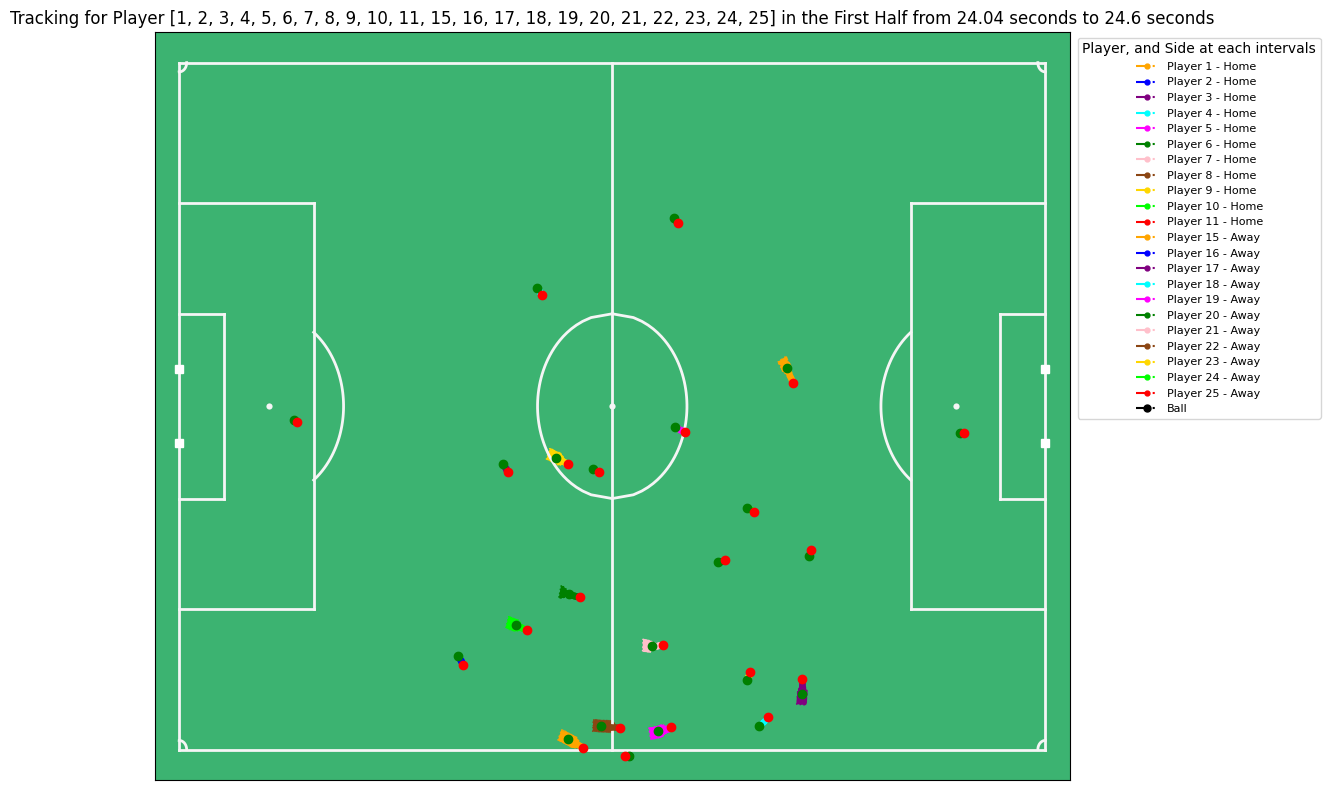

In [8]:
sides = ["Home"] * 11 + ["Away"] * 11
players = list(range(1, 12)) + list(range(15, 26))
game_2_pre.player_visualization(game_2_data.iloc[600:615], players=players, sides=sides, plot_ball=True)
# game_2_pre.player_visualization(game_2_data.iloc[2:3], players=[1,2,3,4,5,6,7,8,9,10,11], sides=["Home"]*11, plot_ball=False)

# Adding extra features to dataset

In [9]:
def calculate_velocity_acceleration_direction(dataset: pd.DataFrame, normalize: bool = True) -> pd.DataFrame:
    """
    Calculates the velocity, acceleration and direction of players and ball in a given dataset.

    Parameters:
        dataset (pandas.DataFrame): The input dataset containing player and ball positions over time.
        normalize (bool): Whether to normalize the calculated values.

    Returns:
        pandas.DataFrame: The original dataset with additional columns for velocity, acceleration and direction.
    """
    temp_data = dataset.copy()
    start_idx = temp_data.columns.get_loc("Time [s]")
    player_columns = temp_data.columns[start_idx + 1:]
    
    # Store all velocities/accelerations for global scaling
    all_velocities = []
    all_accelerations = []
    player_vel_mapping = {}
    player_acc_mapping = {}
    player_sin_mapping = {}
    player_cos_mapping = {}
    
    # First calculate all values
    for i in range(0, player_columns.shape[0] - 1, 2):
        ply_x, ply_y = player_columns[i], player_columns[i + 1]
        
        x_diff = temp_data[ply_x].diff()
        y_diff = temp_data[ply_y].diff()
        time_diff = temp_data["Frame"].diff()
        
        distance = np.sqrt(x_diff ** 2 + y_diff ** 2)
        velocity = distance / time_diff
        acceleration = velocity.diff() / time_diff
        
        # Calculate direction
        vel_x = x_diff / time_diff
        vel_y = y_diff / time_diff
        direction_rad = np.arctan2(vel_y, vel_x)
        
        direction_sine = np.sin(direction_rad)
        direction_cosine = np.cos(direction_rad)
        
        # Store values for later scaling and ordering
        if "ball" in str(ply_x).lower():
            entity = "Ball"
                
            player_vel_mapping[entity] = velocity
            player_acc_mapping[entity] = acceleration
            player_sin_mapping[entity] = direction_sine
            player_cos_mapping[entity] = direction_cosine
            
            all_velocities.extend(velocity.dropna().tolist())
            all_accelerations.extend(acceleration.dropna().tolist())
    
    # Apply global scaling if requested
    if normalize:
        # scaler_vel = MinMaxScaler(feature_range=(-1, 1))
        # scaler_acc = MinMaxScaler(feature_range=(-1, 1))
        scaler_vel = StandardScaler()
        scaler_acc = StandardScaler()
        
        # Fit the scalers on all values
        scaler_vel.fit(np.array(all_velocities).reshape(-1, 1))
        scaler_acc.fit(np.array(all_accelerations).reshape(-1, 1))
        
        # Transform the values
        for entity in player_vel_mapping:
            player_vel_mapping[entity] = scaler_vel.transform(player_vel_mapping[entity].values.reshape(-1, 1)).flatten()
            player_acc_mapping[entity] = scaler_acc.transform(player_acc_mapping[entity].values.reshape(-1, 1)).flatten()
    
    # Add columns to dataframe in the desired order: velocity, acceleration, direction
    for entity in player_vel_mapping.keys():  # Sort to ensure consistent order
        temp_data[f"{entity}_velocity"] = player_vel_mapping[entity]
        temp_data[f"{entity}_acceleration"] = player_acc_mapping[entity]
        temp_data[f"{entity}_direction_sin"] = player_sin_mapping[entity]
        temp_data[f"{entity}_direction_cos"] = player_cos_mapping[entity]
    
    return temp_data

In [10]:
vel_acc_game_1_data = calculate_velocity_acceleration_direction(game_1_data)
vel_acc_game_2_data = calculate_velocity_acceleration_direction(game_2_data)
vel_acc_game_3_data = calculate_velocity_acceleration_direction(game_3_data)

In [11]:
vel_acc_game_1_data

,Period,Frame,Time [s],Home-Player11-x,Home-Player11-y,Home-Player1-x,Home-Player1-y,Home-Player2-x,Home-Player2-y,Home-Player3-x,...,Away-Player23-x,Away-Player23-y,Away-Player24-x,Away-Player24-y,Ball-x,Ball-y,Ball_velocity,Ball_acceleration,Ball_direction_sin,Ball_direction_cos
1,1.0,1.0,0.04,0.00082,0.48238,0.32648,0.65322,0.33701,0.48863,0.30927,...,0.43693,0.05002,0.37833,0.27383,0.45472,0.38709,NaN,NaN,<NA>,<NA>
2,1.0,2.0,0.08,0.00096,0.48238,0.32648,0.65322,0.33701,0.48863,0.30927,...,0.43693,0.05002,0.37833,0.27383,0.49645,0.40656,11.611314,NaN,0.422814,0.906216
3,1.0,3.0,0.12,0.00114,0.48238,0.32648,0.65322,0.33701,0.48863,0.30927,...,0.43693,0.05002,0.37833,0.27383,0.53716,0.42556,11.313757,-0.325623,0.422922,0.906166
4,1.0,4.0,0.16,0.00121,0.48238,0.32622,0.65317,0.33687,0.48988,0.30944,...,0.43644,0.05038,0.37756,0.27473,0.55346,0.42231,3.814385,-8.208957,-0.195538,0.980696
5,1.0,5.0,0.20,0.00129,0.48238,0.32597,0.65269,0.33664,0.49018,0.30948,...,0.43580,0.04977,0.37663,0.27543,0.55512,0.40570,3.833435,0.020944,-0.995043,0.099444
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145002,2.0,145002.0,5800.08,0.90614,0.45355,0.30044,0.68311,0.34157,0.64598,0.31228,...,0.29416,0.48874,0.35600,0.55371,0.03058,0.99726,-0.589333,0.000092,0.0,1.0
145003,2.0,145003.0,5800.12,0.90550,0.45355,0.30044,0.68311,0.34127,0.64583,0.31230,...,0.29373,0.48836,0.35583,0.55283,0.03058,0.99726,-0.589333,0.000092,0.0,1.0
145004,2.0,145004.0,5800.16,0.90492,0.45355,0.30044,0.68311,0.34089,0.64569,0.31214,...,0.29331,0.48800,0.35561,0.55254,0.03058,0.99726,-0.589333,0.000092,0.0,1.0
145005,2.0,145005.0,5800.20,0.90456,0.45356,0.30044,0.68311,0.34056,0.64552,0.31171,...,0.29272,0.48789,0.35532,0.55243,0.03058,0.99726,-0.589333,0.000092,0.0,1.0


In [12]:
vel_acc_game_3_data

,Frame,Time [s],Home-Player11-x,Home-Player11-y,Home-Player1-x,Home-Player1-y,Home-Player2-x,Home-Player2-y,Home-Player3-x,Home-Player3-y,...,Away-Player23-x,Away-Player23-y,Away-Player24-x,Away-Player24-y,Ball-x,Ball-y,Ball_velocity,Ball_acceleration,Ball_direction_sin,Ball_direction_cos
1,1,0.04,0.84722,0.52855,0.65268,0.24792,0.66525,0.46562,0.68103,0.59083,...,0.47050,0.73219,0.48864,0.36357,0.50125,0.48725,NaN,NaN,NaN,NaN
2,2,0.08,0.84722,0.52855,0.65231,0.24513,0.66482,0.46548,0.68095,0.59054,...,0.47040,0.73204,0.48834,0.36362,0.50125,0.48725,-0.823496,NaN,0.0,1.0
3,3,0.12,0.84722,0.52855,0.65197,0.24387,0.66467,0.46537,0.68078,0.59035,...,0.47075,0.73229,0.48814,0.36372,0.50125,0.48725,-0.823496,9.264912e-20,0.0,1.0
4,4,0.16,0.84722,0.52855,0.65166,0.24288,0.66460,0.46488,0.68063,0.58987,...,0.47118,0.73266,0.48793,0.36278,0.50125,0.48725,-0.823496,9.264912e-20,0.0,1.0
5,5,0.20,0.84722,0.52855,0.65141,0.24251,0.66452,0.46469,0.68052,0.58934,...,0.47163,0.73287,0.48784,0.36240,0.50125,0.48725,-0.823496,9.264912e-20,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
143757,143757,5750.28,0.11993,0.51783,0.47808,0.45408,0.49691,0.77311,0.46373,0.62102,...,0.46978,0.62349,0.80792,0.27106,0.89207,0.50485,-0.823496,9.264912e-20,0.0,1.0
143758,143758,5750.32,0.11993,0.51783,0.47786,0.45521,0.49701,0.77429,0.46381,0.62046,...,0.46970,0.62403,0.80712,0.27184,0.89207,0.50485,-0.823496,9.264912e-20,0.0,1.0
143759,143759,5750.36,0.11993,0.51783,0.47743,0.45709,0.49686,0.77555,0.46358,0.62117,...,0.46929,0.62479,0.80582,0.27242,0.89207,0.50485,-0.823496,9.264912e-20,0.0,1.0
143760,143760,5750.40,0.11993,0.51783,0.47669,0.45947,0.49676,0.77638,0.46306,0.62339,...,0.46866,0.62611,0.80444,0.27260,0.89207,0.50485,-0.823496,9.264912e-20,0.0,1.0


In [13]:
game_1_ply_tra = vel_acc_game_1_data.iloc[:, 3:]
game_2_ply_tra = vel_acc_game_2_data.iloc[:, 3:]
game_3_ply_tra = vel_acc_game_3_data.iloc[:, 2:] # This is different

In [14]:
game_2_ply_tra

,Home-Player11-x,Home-Player11-y,Home-Player1-x,Home-Player1-y,Home-Player2-x,Home-Player2-y,Home-Player3-x,Home-Player3-y,Home-Player4-x,Home-Player4-y,...,Away-Player23-x,Away-Player23-y,Away-Player24-x,Away-Player24-y,Ball-x,Ball-y,Ball_velocity,Ball_acceleration,Ball_direction_sin,Ball_direction_cos
1,0.94275,0.50413,0.64812,0.28605,0.67752,0.42803,0.69882,0.55606,0.64348,0.76253,...,0.50177,0.50145,0.49517,0.36234,0.50216,0.50376,NaN,NaN,<NA>,<NA>
2,0.94275,0.50413,0.64812,0.28605,0.67752,0.42803,0.69882,0.55606,0.64348,0.76253,...,0.50177,0.50145,0.49517,0.36234,0.50216,0.50376,-0.680811,NaN,0.0,1.0
3,0.94275,0.50413,0.64812,0.28605,0.67752,0.42803,0.69882,0.55606,0.64348,0.76253,...,0.50177,0.50145,0.49517,0.36234,0.50216,0.50376,-0.680811,-4.228510e-19,0.0,1.0
4,0.94275,0.50413,0.64812,0.28605,0.67752,0.42803,0.69882,0.55606,0.64348,0.76253,...,0.50177,0.50145,0.49517,0.36234,0.50216,0.50376,-0.680811,-4.228510e-19,0.0,1.0
5,0.94275,0.50413,0.64812,0.28605,0.67752,0.42803,0.69882,0.55606,0.64348,0.76253,...,0.50177,0.50145,0.49517,0.36234,0.50216,0.50376,-0.680811,-4.228510e-19,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
141152,0.06285,0.51243,0.38499,0.15356,0.22558,0.41355,0.27142,0.32209,0.40837,0.14449,...,0.26855,0.61845,0.36760,0.12496,0.40958,-0.03891,-0.680811,-4.228510e-19,0.0,1.0
141153,0.06285,0.51243,0.38499,0.15356,0.22558,0.41355,0.27142,0.32209,0.40837,0.14449,...,0.26855,0.61845,0.36760,0.12496,0.40958,-0.03891,-0.680811,-4.228510e-19,0.0,1.0
141154,0.06285,0.51243,0.38499,0.15356,0.22558,0.41355,0.27142,0.32209,0.40837,0.14449,...,0.26855,0.61845,0.36760,0.12496,0.40958,-0.03891,-0.680811,-4.228510e-19,0.0,1.0
141155,0.06285,0.51243,0.38499,0.15356,0.22558,0.41355,0.27142,0.32209,0.40837,0.14449,...,0.26855,0.61845,0.36760,0.12496,0.40958,-0.03891,-0.680811,-4.228510e-19,0.0,1.0


In [15]:
# game_1_player_data = get_frame_data(game_1_ply_tra, columns=game_1_ply_tra.columns[0:46:2], feature="direction").fillna(0)
# game_2_player_data = get_frame_data(game_2_ply_tra, columns=game_2_ply_tra.columns[0:46:2], feature="direction").fillna(0)
# game_3_player_data = get_frame_data(game_3_ply_tra, columns=game_3_ply_tra.columns[0:46:2], feature="direction").fillna(0)

In [16]:
game_1_player_data = game_1_ply_tra.fillna(0).copy()
game_2_player_data = game_2_ply_tra.fillna(0).copy()
game_3_player_data = game_3_ply_tra.fillna(0).copy()

In [17]:
game_1_player_data

,Home-Player11-x,Home-Player11-y,Home-Player1-x,Home-Player1-y,Home-Player2-x,Home-Player2-y,Home-Player3-x,Home-Player3-y,Home-Player4-x,Home-Player4-y,...,Away-Player23-x,Away-Player23-y,Away-Player24-x,Away-Player24-y,Ball-x,Ball-y,Ball_velocity,Ball_acceleration,Ball_direction_sin,Ball_direction_cos
1,0.00082,0.48238,0.32648,0.65322,0.33701,0.48863,0.30927,0.35529,0.32137,0.21262,...,0.43693,0.05002,0.37833,0.27383,0.45472,0.38709,0.000000,0.000000,0.0,0.0
2,0.00096,0.48238,0.32648,0.65322,0.33701,0.48863,0.30927,0.35529,0.32137,0.21262,...,0.43693,0.05002,0.37833,0.27383,0.49645,0.40656,11.611314,0.000000,0.422814,0.906216
3,0.00114,0.48238,0.32648,0.65322,0.33701,0.48863,0.30927,0.35529,0.32137,0.21262,...,0.43693,0.05002,0.37833,0.27383,0.53716,0.42556,11.313757,-0.325623,0.422922,0.906166
4,0.00121,0.48238,0.32622,0.65317,0.33687,0.48988,0.30944,0.35554,0.32142,0.21241,...,0.43644,0.05038,0.37756,0.27473,0.55346,0.42231,3.814385,-8.208957,-0.195538,0.980696
5,0.00129,0.48238,0.32597,0.65269,0.33664,0.49018,0.30948,0.35528,0.32136,0.21159,...,0.43580,0.04977,0.37663,0.27543,0.55512,0.40570,3.833435,0.020944,-0.995043,0.099444
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145002,0.90614,0.45355,0.30044,0.68311,0.34157,0.64598,0.31228,0.67513,0.11428,0.92765,...,0.29416,0.48874,0.35600,0.55371,0.03058,0.99726,-0.589333,0.000092,0.0,1.0
145003,0.90550,0.45355,0.30044,0.68311,0.34127,0.64583,0.31230,0.67529,0.11428,0.92765,...,0.29373,0.48836,0.35583,0.55283,0.03058,0.99726,-0.589333,0.000092,0.0,1.0
145004,0.90492,0.45355,0.30044,0.68311,0.34089,0.64569,0.31214,0.67501,0.11428,0.92765,...,0.29331,0.48800,0.35561,0.55254,0.03058,0.99726,-0.589333,0.000092,0.0,1.0
145005,0.90456,0.45356,0.30044,0.68311,0.34056,0.64552,0.31171,0.67468,0.11428,0.92765,...,0.29272,0.48789,0.35532,0.55243,0.03058,0.99726,-0.589333,0.000092,0.0,1.0


In [18]:
game_1_player_data = add_shot_prediction_features(game_1_player_data)
game_2_player_data = add_shot_prediction_features(game_2_player_data)
game_3_player_data = add_shot_prediction_features(game_3_player_data)

In [19]:
game_1_player_data

,Home-Player11-x,Home-Player11-y,Home-Player1-x,Home-Player1-y,Home-Player2-x,Home-Player2-y,Home-Player3-x,Home-Player3-y,Home-Player4-x,Home-Player4-y,...,Away-Player24-x,Away-Player24-y,Ball-x,Ball-y,Ball_velocity,Ball_acceleration,Ball_direction_sin,Ball_direction_cos,Ball_nearest_goal_distance,Ball_shot_probability
1,0.00082,0.48238,0.32648,0.65322,0.33701,0.48863,0.30927,0.35529,0.32137,0.21262,...,0.37833,0.27383,0.45472,0.38709,0.000000,0.000000,0.0,0.0,0.468528,0.0
2,0.00096,0.48238,0.32648,0.65322,0.33701,0.48863,0.30927,0.35529,0.32137,0.21262,...,0.37833,0.27383,0.49645,0.40656,11.611314,0.000000,0.422814,0.906216,0.505167,0.0
3,0.00114,0.48238,0.32648,0.65322,0.33701,0.48863,0.30927,0.35529,0.32137,0.21262,...,0.37833,0.27383,0.53716,0.42556,11.313757,-0.325623,0.422922,0.906166,0.468788,0.0
4,0.00121,0.48238,0.32622,0.65317,0.33687,0.48988,0.30944,0.35554,0.32142,0.21241,...,0.37756,0.27473,0.55346,0.42231,3.814385,-8.208957,-0.195538,0.980696,0.453248,0.0
5,0.00129,0.48238,0.32597,0.65269,0.33664,0.49018,0.30948,0.35528,0.32136,0.21159,...,0.37663,0.27543,0.55512,0.40570,3.833435,0.020944,-0.995043,0.099444,0.454764,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145002,0.90614,0.45355,0.30044,0.68311,0.34157,0.64598,0.31228,0.67513,0.11428,0.92765,...,0.35600,0.55371,0.03058,0.99726,-0.589333,0.000092,0.0,1.0,0.498199,0.0
145003,0.90550,0.45355,0.30044,0.68311,0.34127,0.64583,0.31230,0.67529,0.11428,0.92765,...,0.35583,0.55283,0.03058,0.99726,-0.589333,0.000092,0.0,1.0,0.498199,0.0
145004,0.90492,0.45355,0.30044,0.68311,0.34089,0.64569,0.31214,0.67501,0.11428,0.92765,...,0.35561,0.55254,0.03058,0.99726,-0.589333,0.000092,0.0,1.0,0.498199,0.0
145005,0.90456,0.45356,0.30044,0.68311,0.34056,0.64552,0.31171,0.67468,0.11428,0.92765,...,0.35532,0.55243,0.03058,0.99726,-0.589333,0.000092,0.0,1.0,0.498199,0.0


# Classification

In [20]:
game_1_event = prepare_event_data("data/Sample_Game_1/Sample_Game_1_RawEventsData.csv", game_1_data)
game_2_event = prepare_event_data("data/Sample_Game_2/Sample_Game_2_RawEventsData.csv", game_2_data)
game_3_event = prepare_json_event_data("data/Sample_Game_3/Sample_Game_3_events.json", game_3_data)

In [21]:
game_1_event

,Type
3,PASS
4,PASS
5,PASS
6,PASS
7,PASS
...,...
143614,BALL LOST
143615,BALL LOST
143616,BALL LOST
143617,BALL LOST


In [22]:
game_2_event

,Type
146,PASS
147,PASS
148,PASS
149,PASS
150,PASS
...,...
141152,BALL OUT
141153,BALL OUT
141154,BALL OUT
141155,BALL OUT


In [23]:
game_3_event

,Type
384,PASS
385,PASS
386,PASS
387,PASS
388,PASS
...,...
143529,PASS
143530,PASS
143531,PASS
143532,PASS


In [24]:
common_indices = game_1_event.index.intersection(game_1_player_data.index)
X_1 = game_1_player_data.loc[common_indices]
y_1 = game_1_event.loc[common_indices]

assert X_1.shape[0] == y_1.shape[0]

In [25]:
common_indices = game_2_event.index.intersection(game_2_player_data.index)
X_2 = game_2_player_data.loc[common_indices]
y_2 = game_2_event.loc[common_indices]

assert X_2.shape[0] == y_2.shape[0]

In [26]:
common_indices = game_3_event.index.intersection(game_3_player_data.index)
X_3 = game_3_player_data.loc[common_indices]
y_3 = game_3_event.loc[common_indices]

assert X_3.shape[0] == y_3.shape[0]

In [27]:
X_1

,Home-Player11-x,Home-Player11-y,Home-Player1-x,Home-Player1-y,Home-Player2-x,Home-Player2-y,Home-Player3-x,Home-Player3-y,Home-Player4-x,Home-Player4-y,...,Away-Player24-x,Away-Player24-y,Ball-x,Ball-y,Ball_velocity,Ball_acceleration,Ball_direction_sin,Ball_direction_cos,Ball_nearest_goal_distance,Ball_shot_probability
3,0.00114,0.48238,0.32648,0.65322,0.33701,0.48863,0.30927,0.35529,0.32137,0.21262,...,0.37833,0.27383,0.53716,0.42556,11.313757,-0.325623,0.422922,0.906166,0.468788,0.0
4,0.00121,0.48238,0.32622,0.65317,0.33687,0.48988,0.30944,0.35554,0.32142,0.21241,...,0.37756,0.27473,0.55346,0.42231,3.814385,-8.208957,-0.195538,0.980696,0.453248,0.0
5,0.00129,0.48238,0.32597,0.65269,0.33664,0.49018,0.30948,0.35528,0.32136,0.21159,...,0.37663,0.27543,0.55512,0.40570,3.833435,0.020944,-0.995043,0.099444,0.454764,0.0
6,0.00140,0.48238,0.32581,0.65159,0.33637,0.48966,0.30978,0.35479,0.32159,0.21051,...,0.37557,0.27673,0.55677,0.38909,3.833172,-0.000195,-0.995102,0.098851,0.456896,0.0
7,0.00140,0.48238,0.32570,0.65037,0.33624,0.48919,0.31015,0.35439,0.32198,0.20921,...,0.37439,0.27751,0.55842,0.37248,3.833172,0.000092,-0.995102,0.098851,0.459624,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
143614,0.87621,0.48890,0.25147,0.54818,0.47196,0.44820,0.50936,0.57808,0.11104,0.67714,...,0.29910,0.56158,0.08382,0.62709,0.755895,-0.001732,-0.777978,-0.628291,0.152242,1.0
143615,0.87601,0.48911,0.25096,0.54821,0.47157,0.44844,0.50890,0.57796,0.11004,0.67616,...,0.29717,0.56196,0.08062,0.62314,0.757562,0.001916,-0.777016,-0.629481,0.147184,1.0
143616,0.87583,0.48933,0.25045,0.54823,0.47120,0.44872,0.50844,0.57788,0.10914,0.67526,...,0.29526,0.56233,0.07743,0.61919,0.755895,-0.001732,-0.777978,-0.628291,0.142133,1.0
143617,0.87564,0.48954,0.24996,0.54830,0.47084,0.44899,0.50799,0.57768,0.10829,0.67433,...,0.29335,0.56268,0.07423,0.61523,0.759621,0.004171,-0.777793,-0.62852,0.137069,1.0



### Adding which team has the ball using distance metrics

In [28]:
def add_team_with_ball(event_df, full_data):
    events_to_leave_out=["FAULT RECEIVED", "SET PIECE", "CARD", "CHALLENGE"]
    game_event_data = pd.read_csv(event_df)    
    game_event_data = game_event_data[~(game_event_data["Type"].isin(events_to_leave_out))]
    event_data = game_event_data.replace("RECOVERY", "BALL LOST")    

    ball_out_idx = full_data.index[
        (full_data["Ball-x"] < 0) | (full_data["Ball-x"] > 1) |
        (full_data["Ball-y"] < 0) | (full_data["Ball-y"] > 1)
    ]

    ball_out_df = pd.DataFrame({
        "Team": "BALL OUT"
    }, index=ball_out_idx)
    
    event_data = event_data[~(event_data["Type"] == "BALL OUT")]
    start_frames = event_data["Start Frame"].iloc[1:].to_numpy()
    end_frames = event_data["End Frame"].iloc[1:].to_numpy()
    event_types = event_data["Team"].iloc[1:].to_numpy()

    # Validation
    assert start_frames.shape == end_frames.shape == event_types.shape

    # Ensure end frames don't exceed data bounds
    end = full_data.index[-1]
    end_frames = np.minimum(end_frames, end)

    # Create frame ranges and unique indices
    frame_ranges = [np.arange(min(i, j), max(i, j) + 1)
                    for i, j in zip(start_frames, end_frames)]
    unique_indices = np.unique(np.concatenate(frame_ranges))

    # Create and populate event DataFrame
    event_df = pd.DataFrame(index=unique_indices, columns=["Team"])
    for s, e, e_t in zip(start_frames, end_frames, event_types):
        event_df.loc[s:e, "Team"] = e_t
        
    combined_event_df = ball_out_df.combine_first(event_df)
    
    return replace_c_with_previous(combined_event_df.dropna())

In [29]:
def add_team_with_ball_json(event_df, full_data):
    import json

    with open(event_df, "r") as f:
        event = json.load(f)
        
    type_ = np.array([])
    team_ = np.array([])
    start_frame = np.array([])
    end_frame = np.array([])
    
    for i in event["data"]:
        t = i["type"]["name"]
        te = i["team"]["name"]
        sf = i["start"]["frame"]
        ef = i["end"]["frame"]
    
        if t != "CARRY" and t != "BALL OUT":
            type_ = np.append(type_, t)
            team_ = np.append(team_, te)
            start_frame = np.append(start_frame, sf)
            end_frame = np.append(end_frame, ef)
    
    
    game_event_data = pd.DataFrame({"Type": type_, "Team": team_, "Start Frame": start_frame.astype(np.int64), "End Frame": end_frame.astype(np.int64)})
    events_to_leave_out=["FAULT RECEIVED", "SET PIECE", "CARD", "CHALLENGE"]

    game_event_data = game_event_data[~(game_event_data["Type"].isin(events_to_leave_out))]


    event_data = game_event_data.replace("RECOVERY", "BALL LOST")
    ball_out_idx = full_data.index[
        (full_data["Ball-x"] < 0) | (full_data["Ball-x"] > 1) |
        (full_data["Ball-y"] < 0) | (full_data["Ball-y"] > 1)
    ]

    ball_out_df = pd.DataFrame({
        "Team": "BALL OUT"
    }, index=ball_out_idx)
    
    event_data = event_data[~(event_data["Type"] == "BALL OUT")]
    start_frames = event_data["Start Frame"].iloc[1:].to_numpy()
    end_frames = event_data["End Frame"].iloc[1:].to_numpy()
    event_types = event_data["Team"].iloc[1:].to_numpy()

    # Validation
    assert start_frames.shape == end_frames.shape == event_types.shape

    # Ensure end frames don't exceed data bounds
    end = full_data.index[-1]
    end_frames = np.minimum(end_frames, end)

    # Create frame ranges and unique indices
    frame_ranges = [np.arange(min(i, j), max(i, j) + 1)
                    for i, j in zip(start_frames, end_frames)]
    unique_indices = np.unique(np.concatenate(frame_ranges))

    # Create and populate event DataFrame
    event_df = pd.DataFrame(index=unique_indices, columns=["Team"])
    for s, e, e_t in zip(start_frames, end_frames, event_types):
        event_df.loc[s:e, "Team"] = e_t
        
    combined_event_df = ball_out_df.combine_first(event_df)
    
    return replace_c_with_previous(combined_event_df.dropna())

In [30]:
def replace_c_with_previous(df):
    prev_value = None
    new_types = []

    for val in df['Team']:
        if val != 'BALL OUT':
            prev_value = val
            new_types.append(val)
        else:
            new_types.append(prev_value)

    df['Team'] = new_types
    return df

In [31]:
def add_ball_with(closest_to_ball: pd.DataFrame):
    # Assume the column of interest is the first column.
    col = closest_to_ball.iloc[:, 0].str.lower()
    
    # Use numpy.where to vectorize the assignment.
    team = np.where(col.str.startswith("home"), 0, 
                    np.where(col.str.startswith("away"), 1, np.nan))
    
    return team

def add_ball_with_json(closest_to_ball: pd.DataFrame):
    # Assume the column of interest is the first column.
    col = closest_to_ball.iloc[:, 0].str.lower()
    
    # Use numpy.where to vectorize the assignment.
    team = np.where(col.str.startswith("team a"), 0, 
                    np.where(col.str.startswith("team b"), 1, np.nan))
    
    return team

In [32]:
X_1["Team"] = add_ball_with(add_team_with_ball("data/Sample_Game_1/Sample_Game_1_RawEventsData.csv", game_1_data))
X_2["Team"] = add_ball_with(add_team_with_ball("data/Sample_Game_2/Sample_Game_2_RawEventsData.csv", game_2_data))
X_3["Team"] = add_ball_with_json(add_team_with_ball_json("data/Sample_Game_3/Sample_Game_3_events.json", game_3_data))

In [33]:
X_1

,Home-Player11-x,Home-Player11-y,Home-Player1-x,Home-Player1-y,Home-Player2-x,Home-Player2-y,Home-Player3-x,Home-Player3-y,Home-Player4-x,Home-Player4-y,...,Away-Player24-y,Ball-x,Ball-y,Ball_velocity,Ball_acceleration,Ball_direction_sin,Ball_direction_cos,Ball_nearest_goal_distance,Ball_shot_probability,Team
3,0.00114,0.48238,0.32648,0.65322,0.33701,0.48863,0.30927,0.35529,0.32137,0.21262,...,0.27383,0.53716,0.42556,11.313757,-0.325623,0.422922,0.906166,0.468788,0.0,1.0
4,0.00121,0.48238,0.32622,0.65317,0.33687,0.48988,0.30944,0.35554,0.32142,0.21241,...,0.27473,0.55346,0.42231,3.814385,-8.208957,-0.195538,0.980696,0.453248,0.0,1.0
5,0.00129,0.48238,0.32597,0.65269,0.33664,0.49018,0.30948,0.35528,0.32136,0.21159,...,0.27543,0.55512,0.40570,3.833435,0.020944,-0.995043,0.099444,0.454764,0.0,1.0
6,0.00140,0.48238,0.32581,0.65159,0.33637,0.48966,0.30978,0.35479,0.32159,0.21051,...,0.27673,0.55677,0.38909,3.833172,-0.000195,-0.995102,0.098851,0.456896,0.0,1.0
7,0.00140,0.48238,0.32570,0.65037,0.33624,0.48919,0.31015,0.35439,0.32198,0.20921,...,0.27751,0.55842,0.37248,3.833172,0.000092,-0.995102,0.098851,0.459624,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
143614,0.87621,0.48890,0.25147,0.54818,0.47196,0.44820,0.50936,0.57808,0.11104,0.67714,...,0.56158,0.08382,0.62709,0.755895,-0.001732,-0.777978,-0.628291,0.152242,1.0,0.0
143615,0.87601,0.48911,0.25096,0.54821,0.47157,0.44844,0.50890,0.57796,0.11004,0.67616,...,0.56196,0.08062,0.62314,0.757562,0.001916,-0.777016,-0.629481,0.147184,1.0,0.0
143616,0.87583,0.48933,0.25045,0.54823,0.47120,0.44872,0.50844,0.57788,0.10914,0.67526,...,0.56233,0.07743,0.61919,0.755895,-0.001732,-0.777978,-0.628291,0.142133,1.0,0.0
143617,0.87564,0.48954,0.24996,0.54830,0.47084,0.44899,0.50799,0.57768,0.10829,0.67433,...,0.56268,0.07423,0.61523,0.759621,0.004171,-0.777793,-0.62852,0.137069,1.0,1.0


In [34]:
# away_cols = X_1.columns.str.startswith("Away")
# X_1.loc[:, away_cols] = X_1.loc[:, away_cols] * -1

# away_cols = X_2.columns.str.startswith("Away")
# X_2.loc[:, away_cols] = X_2.loc[:, away_cols] * -1

# away_cols = X_3.columns.str.startswith("Away")
# X_3.loc[:, away_cols] = X_3.loc[:, away_cols] * -1

In [35]:
X_3

,Home-Player11-x,Home-Player11-y,Home-Player1-x,Home-Player1-y,Home-Player2-x,Home-Player2-y,Home-Player3-x,Home-Player3-y,Home-Player4-x,Home-Player4-y,...,Away-Player24-y,Ball-x,Ball-y,Ball_velocity,Ball_acceleration,Ball_direction_sin,Ball_direction_cos,Ball_nearest_goal_distance,Ball_shot_probability,Team
384,0.84896,0.50882,0.63285,0.18320,0.73758,0.39566,0.71792,0.66465,0.55429,0.91139,...,0.36762,0.49724,0.48532,-0.686549,-1.134310e-02,-0.824729,-0.565528,0.497457,0.0,0.0
385,0.84939,0.50864,0.63267,0.18279,0.73773,0.39606,0.71791,0.66512,0.55430,0.91192,...,0.36807,0.49885,0.48702,-0.067931,9.812472e-01,0.726065,0.687626,0.499019,0.0,0.0
386,0.84987,0.50834,0.63248,0.18255,0.73789,0.39654,0.71791,0.66555,0.55430,0.91241,...,0.36846,0.50207,0.49054,0.715981,1.243436e+00,0.737850,0.674965,0.498020,0.0,0.0
387,0.85034,0.50816,0.63230,0.18221,0.73806,0.39692,0.71791,0.66600,0.55430,0.91292,...,0.36886,0.50528,0.49406,0.713805,-3.451980e-03,0.738894,0.673821,0.494756,0.0,0.0
388,0.85080,0.50799,0.63211,0.18188,0.73820,0.39735,0.71787,0.66652,0.55428,0.91342,...,0.36927,0.50850,0.49757,0.713602,-3.223625e-04,0.736893,0.676010,0.491506,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
143529,0.11993,0.51783,0.42811,0.48741,0.43863,0.79777,0.43239,0.63392,0.43707,0.32970,...,0.20334,0.87713,0.53311,1.140643,9.264912e-20,-0.893769,0.448527,0.127253,0.0,1.0
143530,0.11993,0.51783,0.42872,0.48704,0.43895,0.79718,0.43311,0.63370,0.43740,0.32903,...,0.20261,0.87985,0.52767,1.139198,-2.292491e-03,-0.894427,0.447214,0.123295,0.0,1.0
143531,0.11993,0.51783,0.42932,0.48660,0.43928,0.79654,0.43382,0.63342,0.43772,0.32837,...,0.20178,0.88258,0.52223,1.140643,2.292491e-03,-0.893769,0.448527,0.119506,0.0,1.0
143532,0.11993,0.51783,0.42993,0.48618,0.43961,0.79595,0.43452,0.63314,0.43802,0.32764,...,0.20099,0.88531,0.51679,1.140643,9.264912e-20,-0.893769,0.448527,0.115912,0.0,1.0


In [36]:
np.unique(y_1, return_counts=True)

(array(['BALL LOST', 'BALL OUT', 'PASS', 'SHOT'], dtype=object),
 array([10071, 19023, 28145,   546]))

In [37]:
np.unique(y_2, return_counts=True)

(array(['BALL LOST', 'BALL OUT', 'PASS', 'SHOT'], dtype=object),
 array([ 7742, 15537, 32338,   485]))

In [38]:
np.unique(y_3, return_counts=True)

(array(['BALL LOST', 'BALL OUT', 'PASS', 'SHOT'], dtype=object),
 array([11107, 19620, 42896,   391]))

In [39]:
scaler = StandardScaler()
X_1_scaled = X_1.iloc[:, :].values#scaler.fit_transform(X_1)
X_2_scaled = X_2.iloc[:, :].values#scaler.transform(X_2)
X_3_scaled = X_3.iloc[:, :].values#scaler.transform(X_3)

# X_1_scaled = minmax_scale(X_1, axis=1)
# X_2_scaled = minmax_scale(X_2, axis=1)
# X_3_scaled = minmax_scale(X_3, axis=1)

In [40]:
label_encoder = LabelEncoder()
y_1_encoded = label_encoder.fit_transform(y_1)
y_2_encoded = label_encoder.transform(y_2)
y_3_encoded = label_encoder.transform(y_3)

C:\Users\racr\Desktop\Million's workspace\Thesis-main\Thesis-main\Real-Time LLM Football Commentary\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\racr\Desktop\Million's workspace\Thesis-main\Thesis-main\Real-Time LLM Football Commentary\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
C:\Users\racr\Desktop\Million's workspace\Thesis-main\Thesis-main\Real-Time LLM Football Commentary\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y t

In [41]:
print(X_1_scaled.shape)
print(X_2_scaled.shape)
print(X_3_scaled.shape)

(57785, 53)
(56102, 53)
(74014, 53)


In [42]:
X_1_scaled = X_1_scaled[:(X_1_scaled.shape[0] - X_1_scaled.shape[0] % 200)]
y_1_encoded = y_1_encoded[:(y_1_encoded.shape[0] - y_1_encoded.shape[0] % 200)]

X_2_scaled = X_2_scaled[:(X_2_scaled.shape[0] - X_2_scaled.shape[0] % 200)]
y_2_encoded = y_2_encoded[:(y_2_encoded.shape[0] - y_2_encoded.shape[0] % 200)]

X_3_scaled = X_3_scaled[:(X_3_scaled.shape[0] - X_3_scaled.shape[0] % 200)]
y_3_encoded = y_3_encoded[:(y_3_encoded.shape[0] - y_3_encoded.shape[0] % 200)]

In [43]:
print(X_1_scaled.shape)
print(X_2_scaled.shape)
print(X_3_scaled.shape)

(57600, 53)
(56000, 53)
(74000, 53)


In [44]:
print(np.unique(y_1_encoded, return_counts=True))
print(np.unique(y_2_encoded, return_counts=True))
print(np.unique(y_3_encoded, return_counts=True))

(array([0, 1, 2, 3]), array([10050, 19023, 27981,   546]))
(array([0, 1, 2, 3]), array([ 7742, 15435, 32338,   485]))
(array([0, 1, 2, 3]), array([11106, 19620, 42883,   391]))


In [45]:
w_1 = np.unique(y_1_encoded, return_counts=True)[1] + np.unique(y_2_encoded, return_counts=True)[1]
w_2 = np.unique(y_3_encoded, return_counts=True)[1]

weight_1 = np.divide(w_1, w_1.sum(), dtype=np.float32)
weight_2 = np.divide(w_2, w_2.sum(), dtype=np.float32)

In [46]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    device_name = torch.cuda.get_device_name(device)
    print(f"Using {device}: {device_name}")
else:
    device = torch.device("cpu")
    print(f"Using {device} device")

Using cuda: NVIDIA GeForce RTX 4090


In [47]:
np.unique(y_1_encoded).shape, np.unique(y_2_encoded).shape, np.unique(y_3_encoded).shape

((4,), (4,), (4,))

In [48]:
assert X_1_scaled.shape[1] == X_2_scaled.shape[1] == X_3_scaled.shape[1]
# assert np.unique(y_1).shape == np.unique(y_2).shape == np.unique(y_3).shape

lstm_params = {
    "input_size": X_1_scaled.shape[1],
    "hidden_size" : 256,
    "num_layers" : 6,
    "num_classes" : np.unique(y_1_encoded).shape[0],
    "dropout_rate": 0.25,
    "decoder_num_layers": None,
    "use_batch_norm": False,
    "sequence_length": 50,
    "learning_rate": 0.001,
    "batch_size": 1024,
    "num_epochs": 150
}
input_size = lstm_params["input_size"]
sequence_length = lstm_params["sequence_length"]
learning_rate = lstm_params["learning_rate"]
batch_size = lstm_params["batch_size"]
num_epochs = lstm_params["num_epochs"]

In [49]:
class ToTensorSequential:
    def __call__(self, sample):
        X, y = sample['X'], sample['y']
        # Convert both features and labels to tensors
        return {
            'X': torch.tensor(X, dtype=torch.float32),
            'y': torch.tensor(y, dtype=torch.long)
        }
        
transform = v2.Compose([
    ToTensorSequential(),
])

class SequenceDataset(Dataset):
    def __init__(self, X, y, transform=None):
        self.X = X
        self.y = y
        self.transform = transform
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        sample = {"X": self.X[idx], "y": self.y[idx]}
        if self.transform:
            sample = self.transform(sample)
        return sample["X"], sample["y"]


In [ ]:
X_comb = np.concatenate([X_3_scaled, X_2_scaled])
y_comb = np.concatenate((y_3_encoded, y_2_encoded))

X_comb_reshaped = X_comb.reshape(-1, sequence_length, input_size).astype(float)
y_comb_reshaped = y_comb.reshape(-1, sequence_length)

X_1_reshaped = X_1_scaled.reshape(-1, sequence_length, input_size).astype(float)
y_1_reshaped = y_1_encoded.reshape(-1, sequence_length) 

train_dataset = SequenceDataset(X_comb_reshaped, y_comb_reshaped, transform=transform)
validation_dataset = SequenceDataset(X_1_reshaped, y_1_reshaped, transform=transform)

train_loader = DataLoader(
    dataset=train_dataset, 
    batch_size=batch_size, 
    shuffle=False,
)

validation_loader = DataLoader(
    dataset=validation_dataset, 
    batch_size=batch_size, 
    shuffle=False,
)

In [51]:
lstm_model = get_model(LSTM, params=lstm_params).to(device)
lstm_model

LSTM(
  (encoder): Encoder(
    (input_bn): LayerNorm((53,), eps=1e-05, elementwise_affine=True)
    (lstm): LSTM(53, 256, num_layers=6, batch_first=True, dropout=0.25)
  )
  (decoder): Decoder(
    (lstm): LSTM(4, 256, num_layers=6, batch_first=True, dropout=0.25)
    (hidden_bn): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
    (fc): Sequential(
      (0): Linear(in_features=256, out_features=256, bias=True)
      (1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (2): ReLU()
      (3): Dropout(p=0.25, inplace=False)
      (4): Linear(in_features=256, out_features=4, bias=True)
    )
  )
)

In [ ]:
weights = torch.from_numpy(weight_1).to(device)
acc, y_train, y_train_pred, y_true, y_pred = train_model(lstm_model, train_loader, validation_loader, num_epochs, "adam", nn.CrossEntropyLoss(weight=weights), learning_rate, device, is_rnn=True)

In [ ]:
plot_accuracy_history(acc, title=f"using {str(lstm_params)}")
labels = label_encoder.inverse_transform(np.unique(y_1_encoded))
_ = plot_confusion_matrix(y_train=label_encoder.inverse_transform(y_train), y_train_pred=label_encoder.inverse_transform(y_train_pred), y_test=label_encoder.inverse_transform(y_true), 
                          y_pred=label_encoder.inverse_transform(y_pred), labels=labels, split=0, model_name="LSTM")

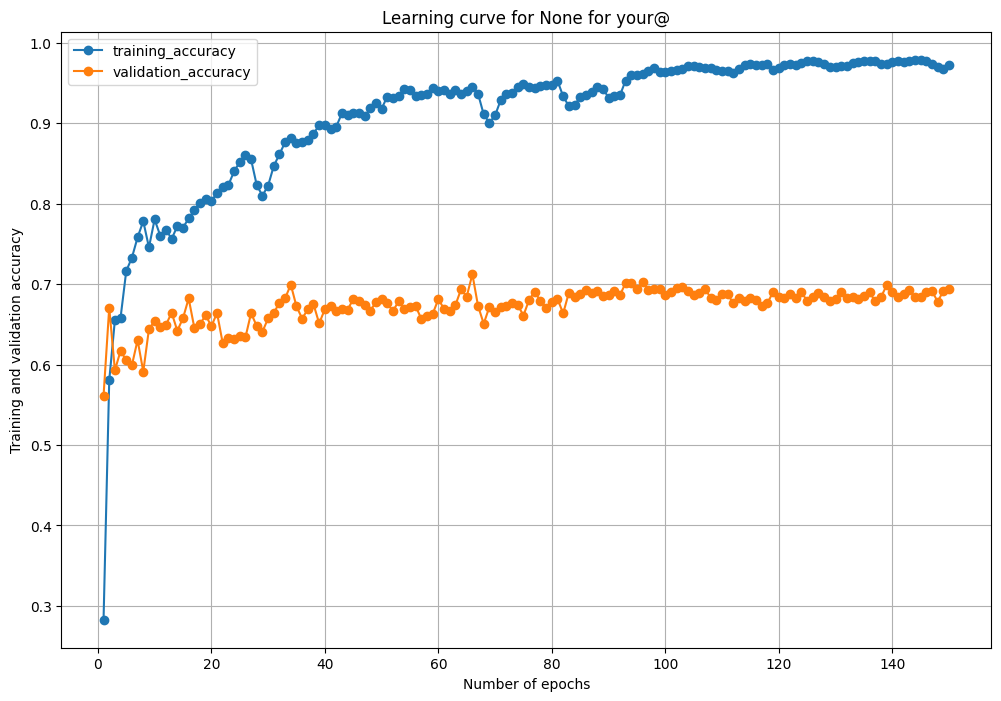

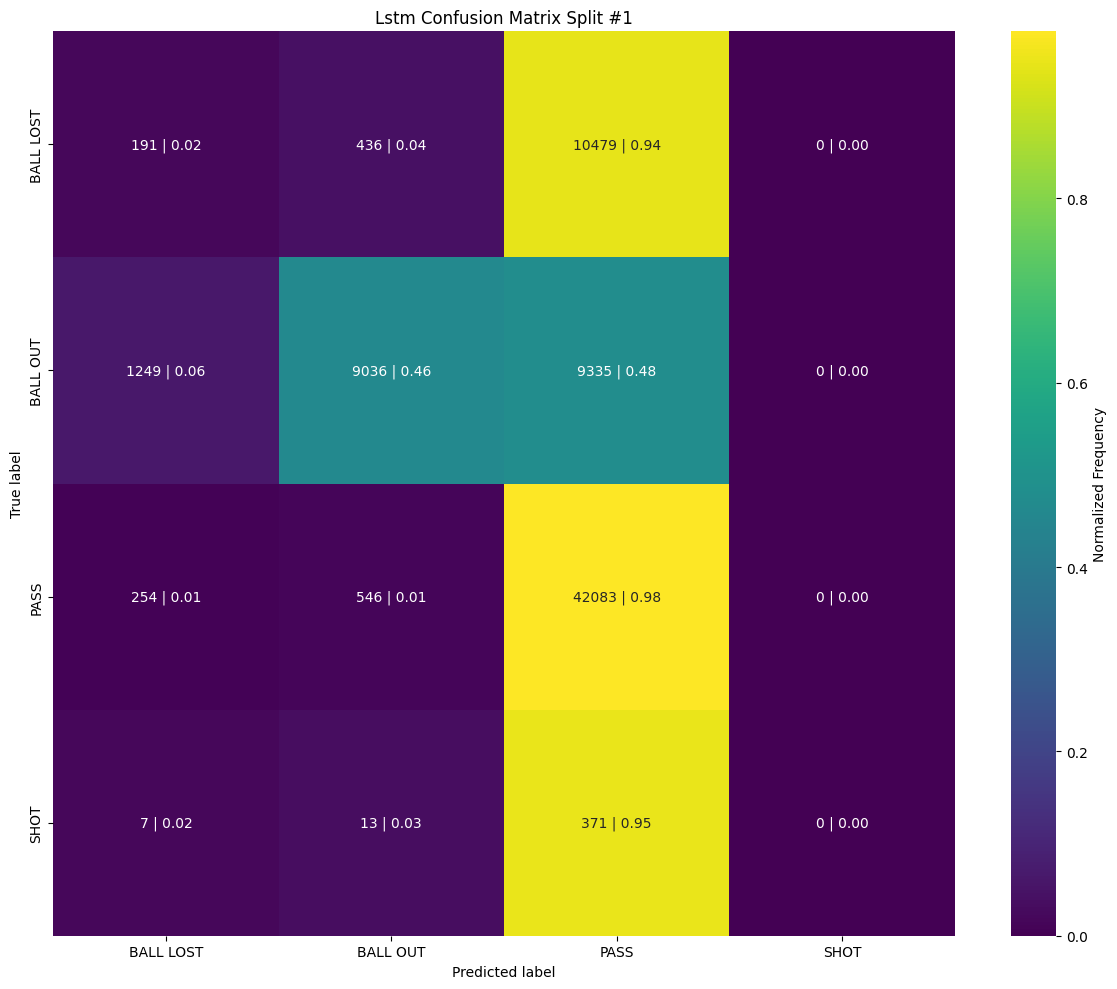

LSTM training accuracy: 97.21%
LSTM testing accuracy: 69.34%

LSTM testing precision: 64.73%
LSTM testing recall: 69.34%
LSTM testing f1: 62.99%




In [66]:
plot_accuracy_history(acc, title="None for your@")
labels = label_encoder.inverse_transform(np.unique(y_1_encoded))
_ = plot_confusion_matrix(y_train=label_encoder.inverse_transform(y_train), y_train_pred=label_encoder.inverse_transform(y_train_pred), y_test=label_encoder.inverse_transform(y_true), 
                          y_pred=label_encoder.inverse_transform(y_pred), labels=labels, split=0, model_name="LSTM")

In [68]:
assert X_1_scaled.shape[1] == X_2_scaled.shape[1] == X_3_scaled.shape[1]
# assert np.unique(y_1).shape == np.unique(y_2).shape == np.unique(y_3).shape

gru_params = {
    "input_size": X_1_scaled.shape[1],
    "hidden_size" : 256,
    "num_layers" : 6,
    "num_classes" : np.unique(y_1_encoded).shape[0],
    "dropout_rate": 0.25,
    "decoder_num_layers": None,
    "use_batch_norm": False,
    "sequence_length": 50,
    "learning_rate": 0.001,
    "batch_size": 1024,
    "num_epochs": 150
}
input_size = gru_params["input_size"]
sequence_length = gru_params["sequence_length"]
learning_rate = gru_params["learning_rate"]
batch_size = gru_params["batch_size"]
num_epochs = gru_params["num_epochs"]

In [69]:
class ToTensorSequential:
    def __call__(self, sample):
        X, y = sample['X'], sample['y']
        # Convert both features and labels to tensors
        return {
            'X': torch.tensor(X, dtype=torch.float32),
            'y': torch.tensor(y, dtype=torch.long)
        }
        
transform = v2.Compose([
    ToTensorSequential(),
])


class SequenceDataset(Dataset):
    def __init__(self, X, y, transform=None):
        self.X = X
        self.y = y
        self.transform = transform
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        sample = {"X": self.X[idx], "y": self.y[idx]}
        if self.transform:
            sample = self.transform(sample)
        return sample["X"], sample["y"]


In [70]:
X_comb = np.concatenate([X_1_scaled, X_2_scaled])
y_comb = np.concatenate((y_1_encoded, y_2_encoded))

X_comb_reshaped = X_comb.reshape(-1, sequence_length, input_size).astype(float)
y_comb_reshaped = y_comb.reshape(-1, sequence_length)

X_3_reshaped = X_3_scaled.reshape(-1, sequence_length, input_size).astype(float)
y_3_reshaped = y_3_encoded.reshape(-1, sequence_length) 

train_dataset = SequenceDataset(X_comb_reshaped, y_comb_reshaped, transform=transform)
validation_dataset = SequenceDataset(X_3_reshaped, y_3_reshaped, transform=transform)

train_loader = DataLoader(
    dataset=train_dataset, 
    batch_size=batch_size, 
    shuffle=True,
)

validation_loader = DataLoader(
    dataset=validation_dataset, 
    batch_size=batch_size, 
    shuffle=False,
)

In [71]:
gru_model = get_model(GRU, params=gru_params).to(device)
gru_model

GRU(
  (encoder): Encoder(
    (input_bn): LayerNorm((53,), eps=1e-05, elementwise_affine=True)
    (gru): GRU(53, 256, num_layers=6, batch_first=True, dropout=0.25)
  )
  (decoder): Decoder(
    (gru): GRU(4, 256, num_layers=6, batch_first=True, dropout=0.25)
    (hidden_bn): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
    (fc): Sequential(
      (0): Linear(in_features=256, out_features=256, bias=True)
      (1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (2): ReLU()
      (3): Dropout(p=0.25, inplace=False)
      (4): Linear(in_features=256, out_features=4, bias=True)
    )
  )
)

In [72]:
acc, y_train, y_train_pred, y_true, y_pred = train_model(gru_model, train_loader, validation_loader, num_epochs, "adam", nn.CrossEntropyLoss(weight=weights), learning_rate, device, is_rnn=True)

Epoch   1/150: Train accuracy: 41.59% | Val accuracy: 58.10% | Train loss: 1.1461 | Val loss: 0.7633 | learning rate: 0.001000 | Precision: 48.88% | Recall: 58.10% | F1: 43.63%
Epoch   2/150: Train accuracy: 53.10% | Val accuracy: 58.77% | Train loss: 0.8569 | Val loss: 0.6540 | learning rate: 0.001000 | Precision: 55.54% | Recall: 58.77% | F1: 44.79%
Epoch   3/150: Train accuracy: 55.50% | Val accuracy: 75.02% | Train loss: 0.7242 | Val loss: 0.4993 | learning rate: 0.001000 | Precision: 63.98% | Recall: 75.02% | F1: 68.78%
Epoch   4/150: Train accuracy: 71.15% | Val accuracy: 75.82% | Train loss: 0.5308 | Val loss: 0.5090 | learning rate: 0.001000 | Precision: 64.94% | Recall: 75.82% | F1: 69.72%
Epoch   5/150: Train accuracy: 76.77% | Val accuracy: 77.79% | Train loss: 0.4327 | Val loss: 0.4431 | learning rate: 0.001000 | Precision: 67.12% | Recall: 77.79% | F1: 71.57%
Epoch   6/150: Train accuracy: 78.58% | Val accuracy: 79.46% | Train loss: 0.3990 | Val loss: 0.4016 | learning rat

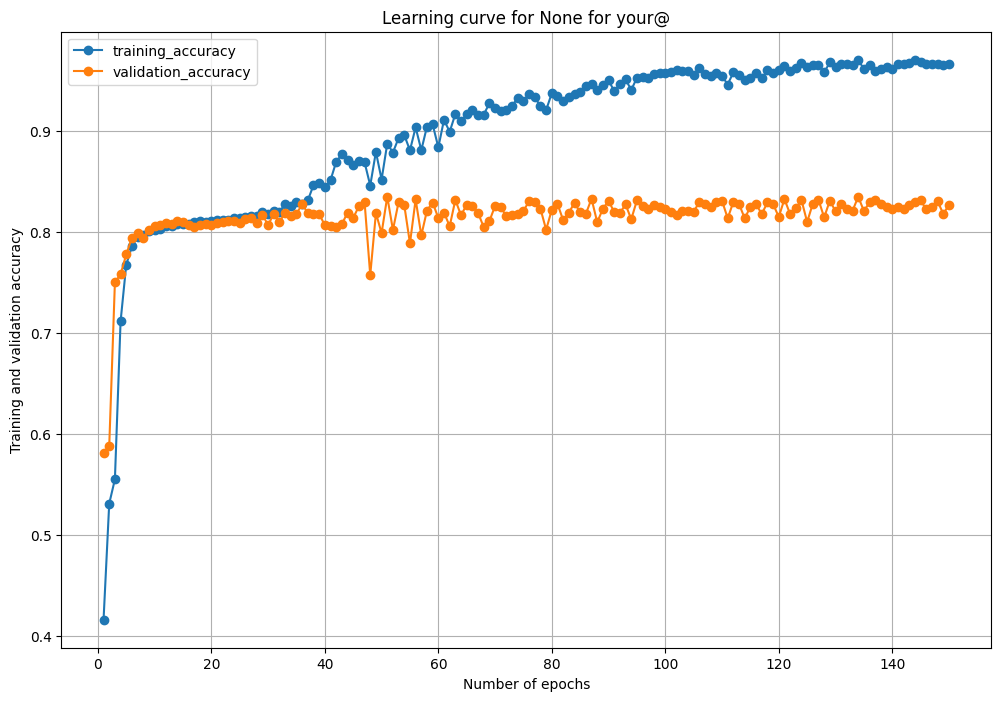

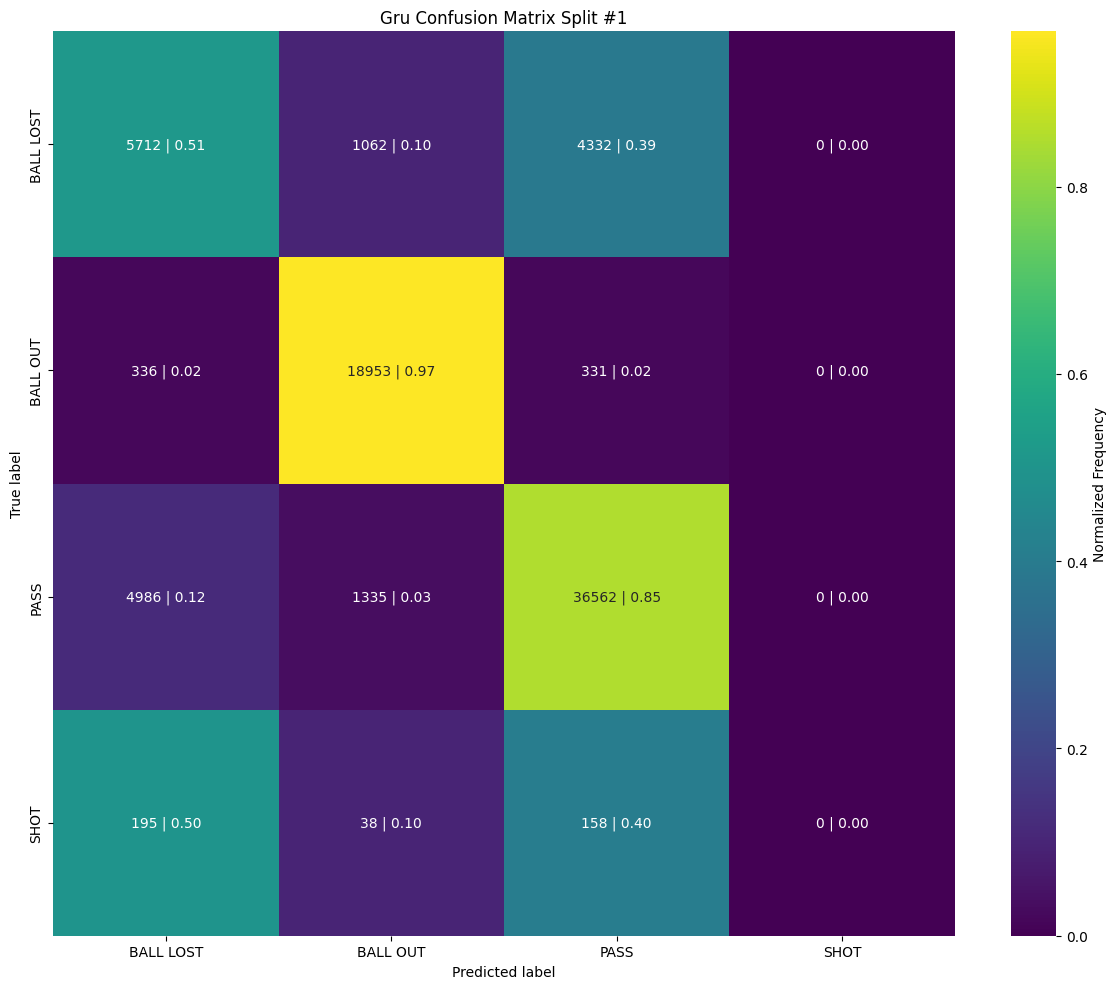

GRU training accuracy: 96.70%
GRU testing accuracy: 82.74%

GRU testing precision: 82.33%
GRU testing recall: 82.74%
GRU testing f1: 82.47%




In [73]:
plot_accuracy_history(acc, title=f"using {str(gru_params)}")
labels = label_encoder.inverse_transform(np.unique(y_1_encoded))
_ = plot_confusion_matrix(y_train=label_encoder.inverse_transform(y_train), y_train_pred=label_encoder.inverse_transform(y_train_pred), y_test=label_encoder.inverse_transform(y_true), 
                          y_pred=label_encoder.inverse_transform(y_pred), labels=labels, split=0, model_name="GRU")

In [ ]:
a, b, c = test_model(nn_model, validation_loader, nn.CrossEntropyLoss(weight=weights), device)

In [11]:
5712/(11107)
# 18953/(19620)
195+38+158

391

In [ ]:
(array(['BALL LOST', 'BALL OUT', 'PASS', 'SHOT'], dtype=object),
 array([10071, 19023, 28145,   546], dtype=int64))
np.unique(label_encoder.inverse_transform(y_2_encoded), return_counts=True)
(array(['BALL LOST', 'BALL OUT', 'PASS', 'SHOT'], dtype=object),
 array([ 7742, 15537, 32338,   485], dtype=int64))
np.unique(label_encoder.inverse_transform(y_3_encoded), return_counts=True)
(array(['BALL LOST', 'BALL OUT', 'PASS', 'SHOT'], dtype=object),
 array([11107, 19620, 42896,   391], dtype=int64))


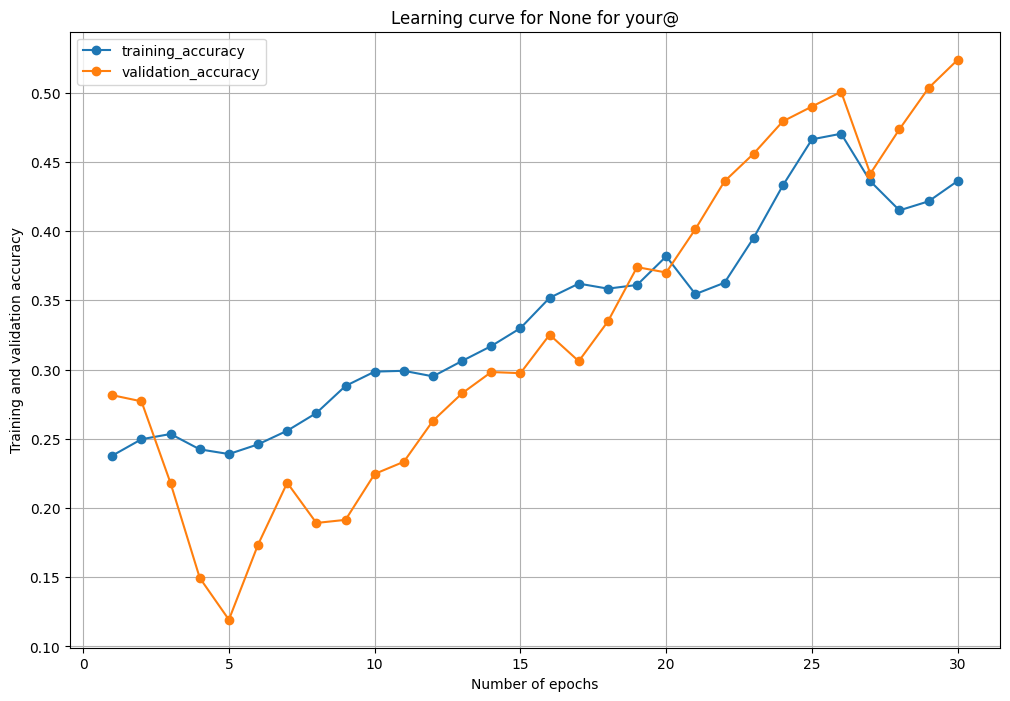

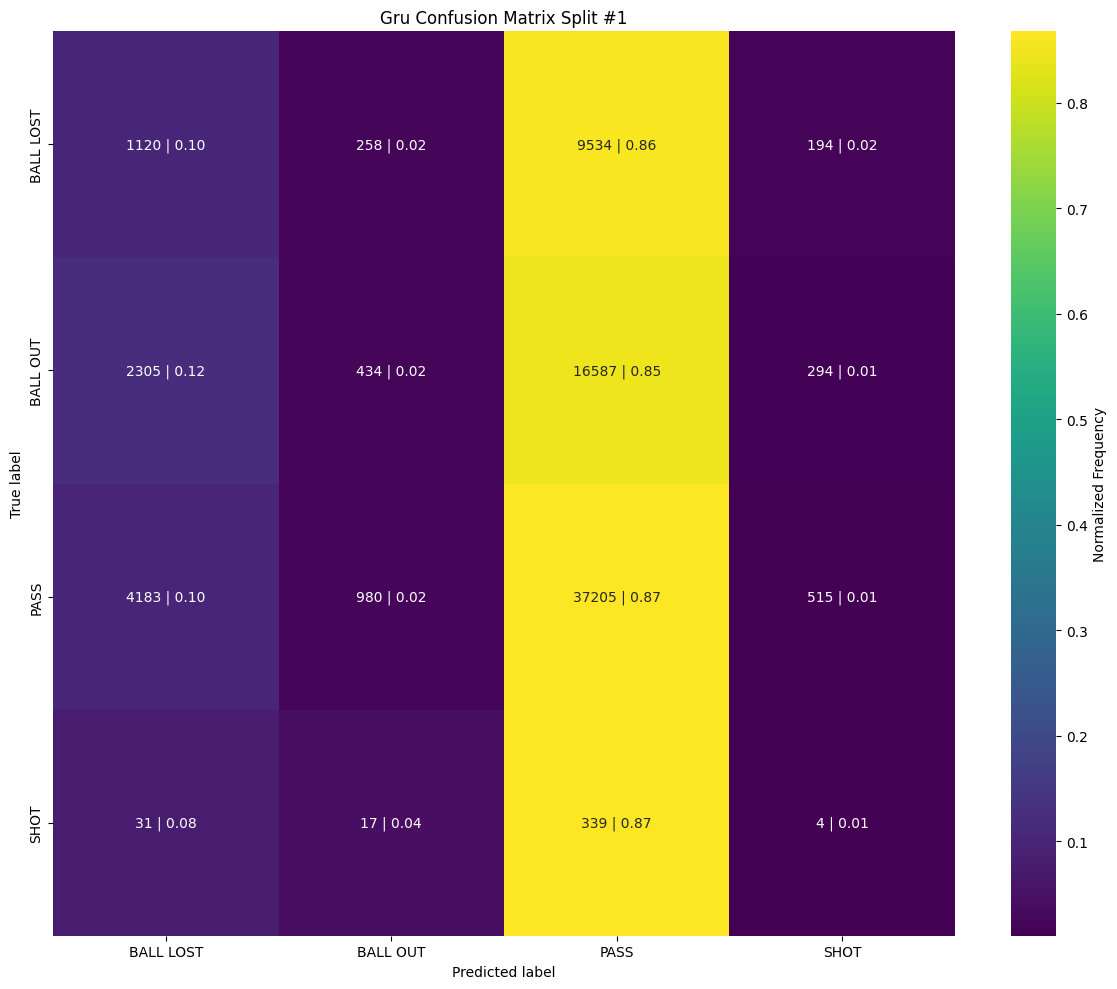

GRU training accuracy: 43.63%
GRU testing accuracy: 52.38%

GRU testing precision: 42.88%
GRU testing recall: 52.38%
GRU testing f1: 43.35%




In [70]:
plot_accuracy_history(acc, title="None for your@")
labels = label_encoder.inverse_transform(np.unique(y_1_encoded))
_ = plot_confusion_matrix(y_train=label_encoder.inverse_transform(y_train), y_train_pred=label_encoder.inverse_transform(y_train_pred), y_test=label_encoder.inverse_transform(y_true), 
                          y_pred=label_encoder.inverse_transform(y_pred), labels=labels, split=0, model_name="GRU")

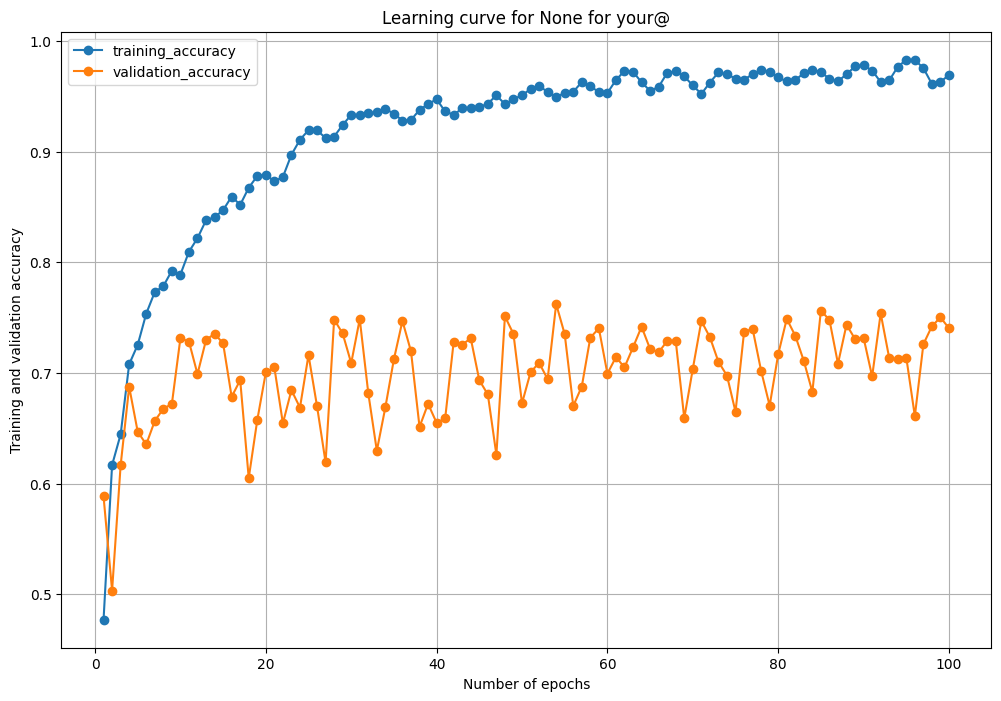

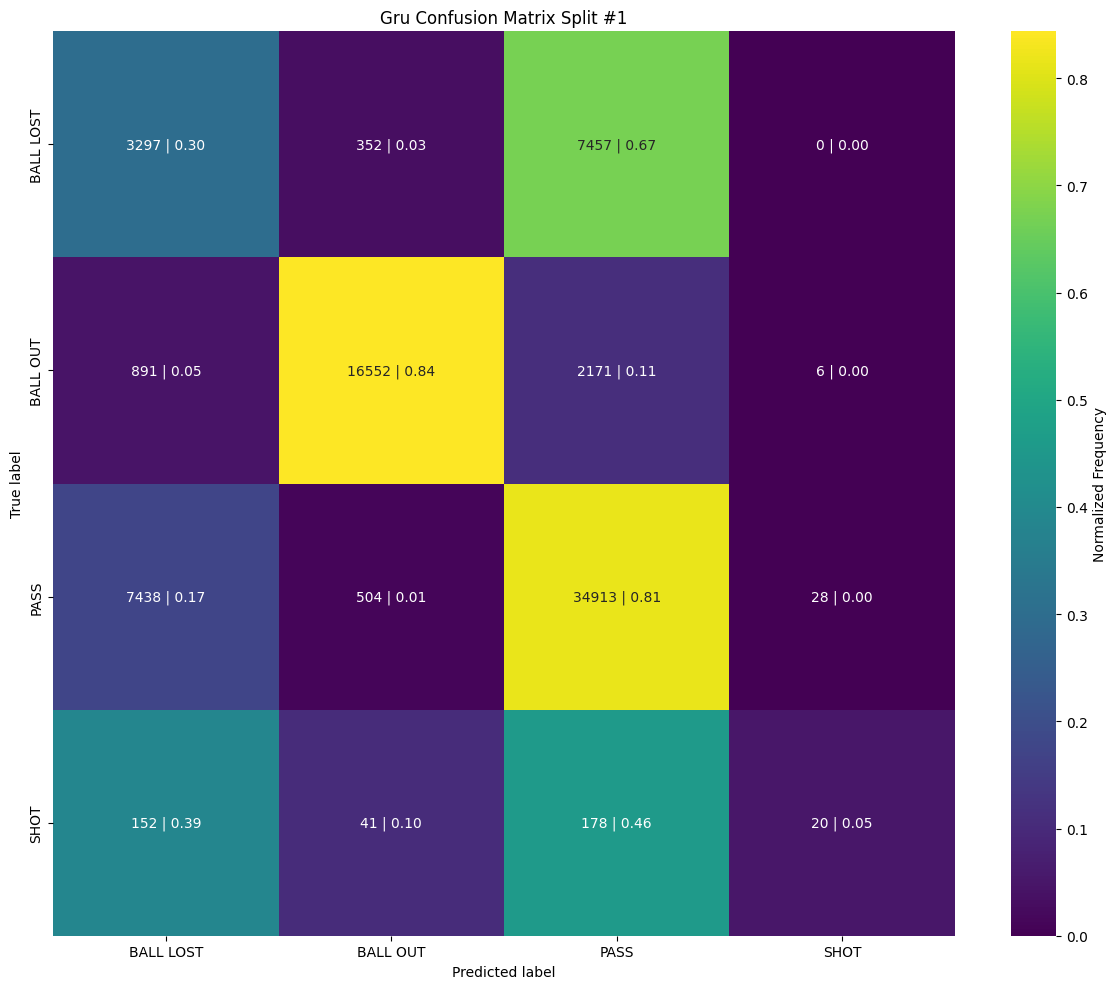

GRU training accuracy: 96.91%
GRU testing accuracy: 74.03%

GRU testing precision: 74.79%
GRU testing recall: 74.03%
GRU testing f1: 74.24%




In [60]:
plot_accuracy_history(acc, title="None for your@")
labels = label_encoder.inverse_transform(np.unique(y_1_encoded))
_ = plot_confusion_matrix(y_train=label_encoder.inverse_transform(y_train), y_train_pred=label_encoder.inverse_transform(y_train_pred), y_test=label_encoder.inverse_transform(y_true), 
                          y_pred=label_encoder.inverse_transform(y_pred), labels=labels, split=0, model_name="GRU")

In [ ]:
25, 36, 48

In [ ]:
Best trial 25: {'batch_size': 512, 'dropout_rate': 0.4086862371340136, 'hidden_size': 256, 'optimizer': 'adam', 'learning_rate': 0.00038819623613215354, 'num_layers': 4, 'sequence_length': 25}
Best accuracy: 0.8583436768774237

In [ ]:
Trial 48 finished with value: 0.8373301638766013 and parameters: {'batch_size': 512, 'dropout_rate': 0.20523009649860546, 'hidden_size': 128, 'optimizer': 'sgd', 'learning_rate': 0.012682942484929386, 'num_layers': 6, 'sequence_length': 25}.

In [60]:
Trial 36 finished with value: 0.8292257189468093 and parameters: {'batch_size': 512, 'dropout_rate': 0.2327694778607767, 'hidden_size': 512, 'optimizer': 'sgd', 'learning_rate': 0.012815264082136263, 'num_layers': 3, 'sequence_length': 25}. Best is trial 25 with value: 0.8583436768774237.

SyntaxError: invalid syntax (4225598917.py, line 1)

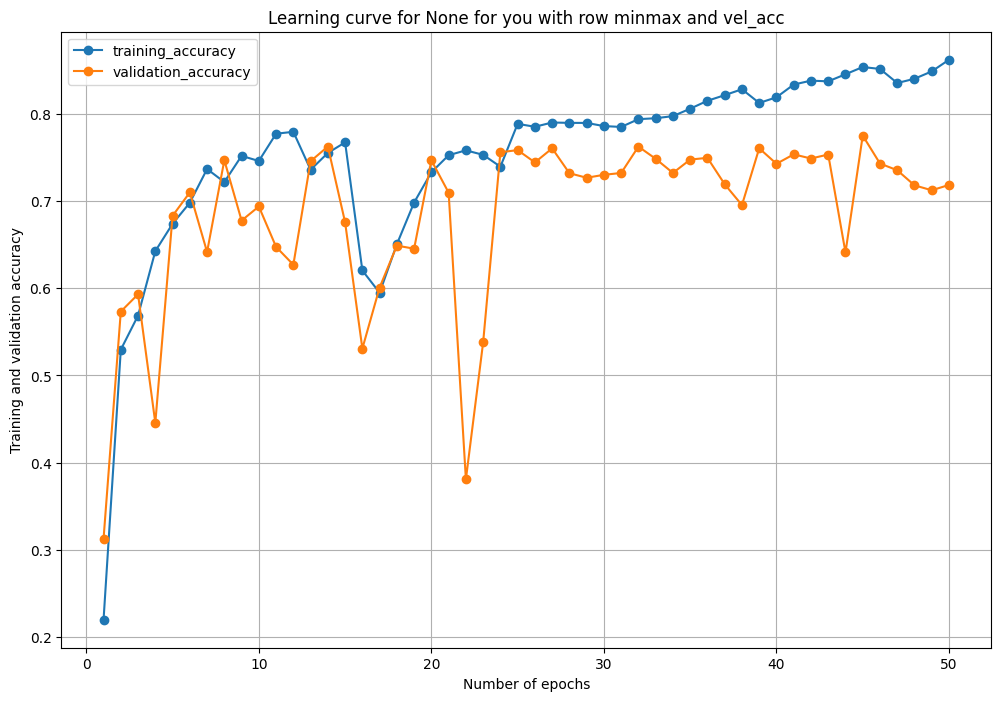

In [68]:
plot_accuracy_history(acc, title="None for you with row minmax and vel_acc")

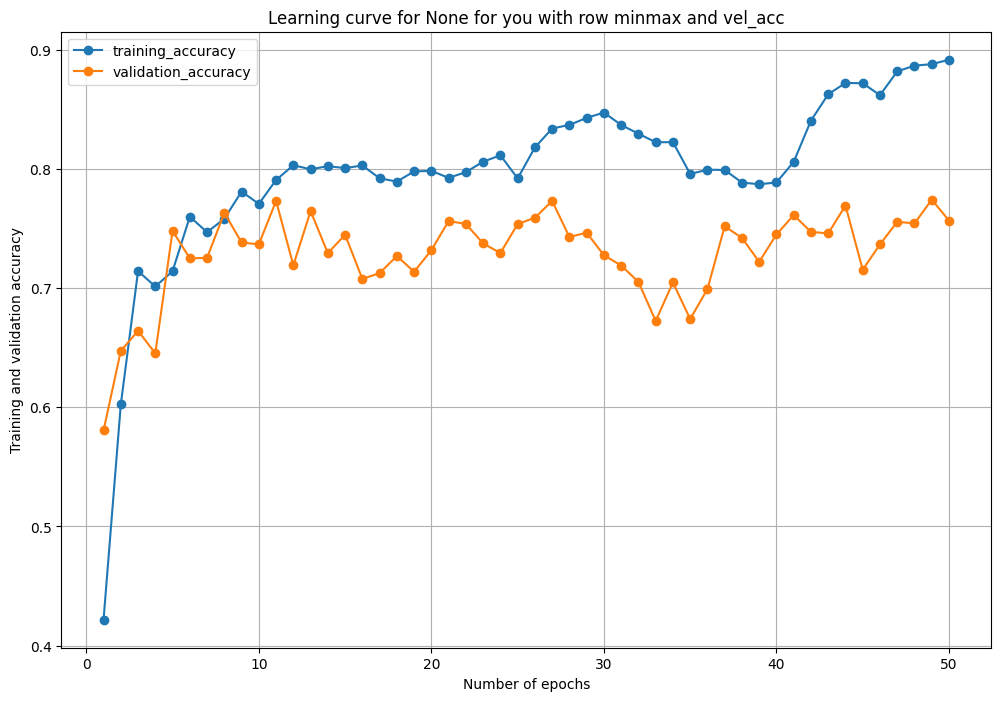

In [56]:
plot_accuracy_history(acc, title="None for you with row minmax and vel_acc")

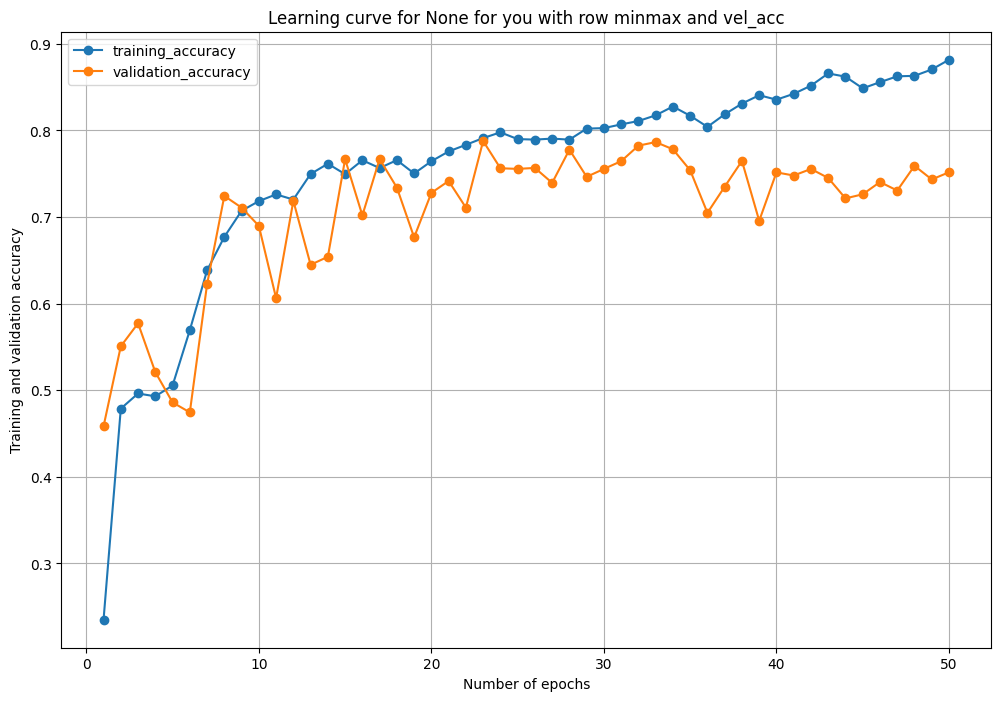

In [88]:
plot_accuracy_history(acc, title="None for you with row minmax and vel_acc")

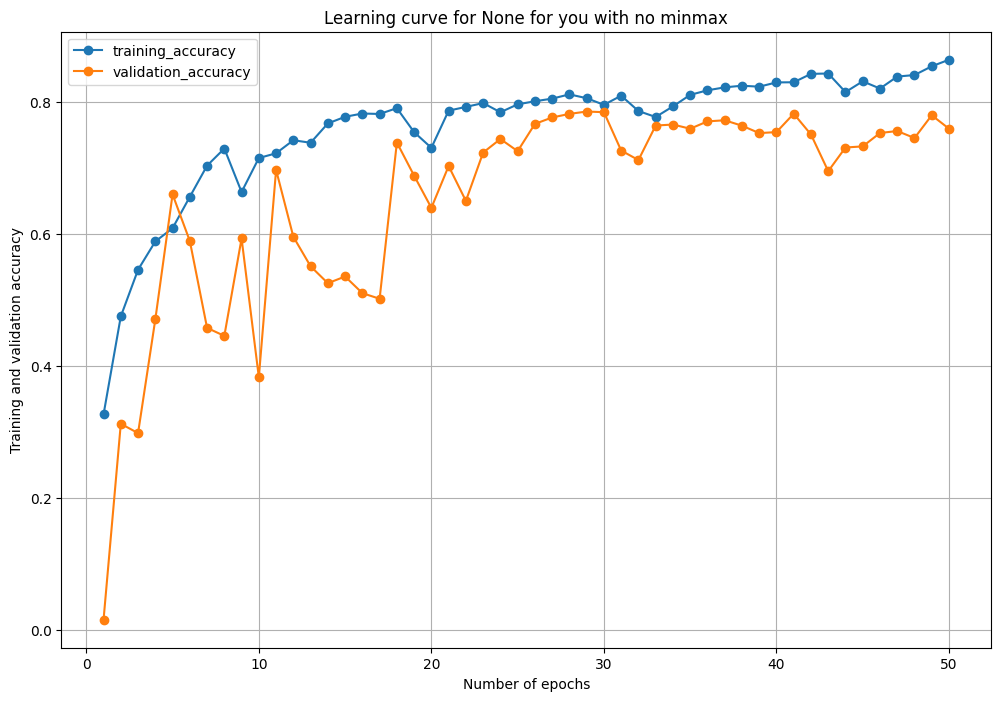

In [89]:
plot_accuracy_history(acc, title="None for you with no minmax")

In [ ]:
plot_accuracy(acc, title="Trial 48 with 50 SL")

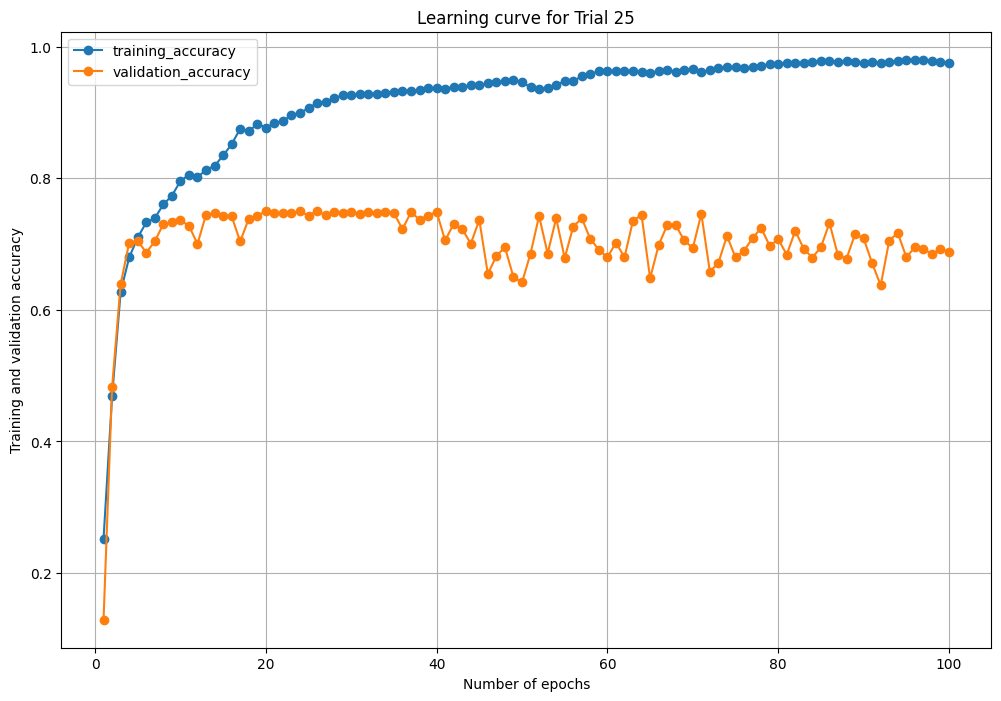

In [75]:
plot_accuracy(acc, title="Trial 25")